In [39]:
# -*- coding: utf-8 -*-
"""
Created on Sun Sep 29 12:58:10 2019

@author: steve
"""
import pandas as pd #與Panel、DataFrame 與 Series 相呼應
import numpy as np #

### read input & output data

In [40]:
x_train=open("../dataset/MackeyGlass/train_X.txt")
x_train=pd.read_csv(x_train, sep="\t",header=0)
y_train=open("../dataset/MackeyGlass/train_y.txt")
y_train=(pd.read_csv(y_train, sep="\t",header=0)).iloc[:,1]

x_test=open("../dataset/MackeyGlass/test_X.txt")
x_test=pd.read_csv(x_test, sep="\t",header=0)
y_test=open("../dataset/MackeyGlass/test_Y_MG_real.txt")
y_test=(pd.read_csv(y_test, sep="\t",header=0)).iloc[:,1]

### using input label

In [41]:
data_in=x_train
print(f'shape of data_in:{np.array(data_in).shape}')
data_real_out=y_train
print(f'shape of data_real_out:{np.array(data_real_out).shape}')
test_in=x_test
test_real_out=y_test

shape of data_in:(500, 5)
shape of data_real_out:(500,)


### data normalization

In [42]:
data_in_max=data_in.max()
data_in_min=data_in.min()
data_in_norm=(data_in-data_in_min)/(data_in_max-data_in_min)
data_in_norm=np.asarray(data_in_norm)
# print(f'shape of data_in_norm: {np.array(data_in_norm).shape}')

data_real_out_max=data_real_out.max()
data_real_out_min=data_real_out.min()
data_real_out_norm=(data_real_out-data_real_out_min)/(data_real_out_max-data_real_out_min)
data_real_out_norm=np.asarray(data_real_out_norm)
# print(f'shape of data_real_out: {np.array(data_real_out).shape}')

test_in_max=test_in.max()
test_in_min=test_in.min()
test_in_norm=(test_in-test_in_min)/(test_in_max-test_in_min)
test_in_norm=np.asarray(test_in_norm)

test_real_out_max=test_real_out.max()
test_real_out_min=test_real_out.min()
test_real_out_norm=(test_real_out-test_real_out_min)/(test_real_out_max-test_real_out_min)
test_real_out_norm=np.asarray(test_real_out_norm)

### Build Model

In [43]:
#define error function & calculate model's output error
def np_RMSE(output,output_pred):
    rmserror=0
    for i in range(len(output)):
        rmserror=rmserror+np.square(output[i]-output_pred[i])
    rmserror=np.sqrt(rmserror/len(output))
    return rmserror

def np_R2(output,output_pred):
    return np.square(np.corrcoef(output.reshape(np.size(output)),output_pred.reshape(np.size(output_pred)), False)[1,0])

#### 1-b. 以交叉驗證方式訓練BPNN模式，列初步同分組組合之RMSE與$R^2$值

In [44]:
from keras.models import Sequential,load_model
from keras import backend as K
from keras.layers import Dense
from keras.layers.core import Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.optimizers import adam_v2
#from keras.layers.normalization import BatchNormalization
from sklearn.model_selection import KFold
from keras.callbacks import History
from keras.metrics import mean_squared_error as mserr

history = History()

RMSE_history_list = []
R2_history_list = []
seed = 7
best_RMSE = np.inf
kfold = KFold(n_splits=3, shuffle=False)
for train, validation in kfold.split(data_in_norm, data_real_out_norm):
    K.clear_session()

    # 模型結構
    model=Sequential()
    model.add(Dense(5,kernel_initializer='normal'))
    #model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(5,kernel_initializer='normal'))
    #model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(1))

    # 模型相關設定
    learning_rate=1e-4 #設定學習速率
    adam = adam_v2.Adam(lr=learning_rate) #設定的優化器
    model.compile(optimizer=adam,loss="mse") #執行設定好的優化器和誤差函數
    # earlystopper = EarlyStopping(monitor='val_loss',
    #                              patience=10,
    #                              verbose=0) #設定early stopping的參數
    # checkpoint =ModelCheckpoint("bp-model.hdf5",save_best_only=True) #設定儲存路徑
    # save_best_only=True: 每次迭代儲存模式，我設定了最終只儲存最佳的模式(當驗證誤差最小的時候)
    # callback_list=[earlystopper,checkpoint]
    model.fit(data_in_norm[train],
              data_real_out_norm[train],
              epochs=200,   #100
              batch_size=8,
              # validation_split=0.2,
              workers=8,
              # callbacks=callback_list
              )
    prediction = np.squeeze(model.predict(data_in_norm[validation]))
    current_RMSE = np_RMSE(prediction, data_real_out_norm[validation])
    current_R2 = np_R2(prediction, data_real_out_norm[validation])
    RMSE_history_list.append(current_RMSE)
    R2_history_list.append(current_R2)

    if (current_RMSE < best_RMSE):
        best_RMSE = current_RMSE
        model.save("bp-model.hdf5")
        print(f'best model updated!')
    #執行模式訓練并且把設定好的early stopping以及儲存模式參數套用到訓練中

#more details reference: https://keras.io/


Epoch 1/200


C:\Users\woody\AppData\Roaming\Python\Python38\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


42/42 [==============================] - 0s 2ms/step - loss: 0.3740
Epoch 2/200
42/42 [==============================] - 0s 2ms/step - loss: 0.3617
Epoch 3/200
42/42 [==============================] - 0s 2ms/step - loss: 0.3492
Epoch 4/200
42/42 [==============================] - 0s 2ms/step - loss: 0.3365
Epoch 5/200
42/42 [==============================] - 0s 2ms/step - loss: 0.3237
Ep

In [45]:
df = pd.DataFrame(list(zip(RMSE_history_list, R2_history_list)),
                  columns=['RMSE', 'R2'])

df

,RMSE,R2
0,0.146732,0.772469
1,0.131389,0.725118
2,0.252376,0.102868


### Model forecasting result

In [46]:
#model forecasting result
model=load_model("bp-model.hdf5") #把儲存好的最佳模式讀入
batch_size=8
pred_train=(model.predict(data_in_norm,batch_size=batch_size))*(data_real_out_max-data_real_out_min)+data_real_out_min #針對訓練資料做預測
pred_test=(model.predict(test_in_norm,batch_size=batch_size))*(test_real_out_max-test_real_out_min)+test_real_out_min #針對測試資料做預測

rmse=[];r2=[];
rmse.append(np_RMSE(np.asarray(data_real_out),pred_train))
rmse.append(np_RMSE(np.asarray(test_real_out),pred_test))
r2.append(np_R2(np.asarray(data_real_out),pred_train))
r2.append(np_R2(np.asarray(test_real_out),pred_test))

rmse=np.asarray(rmse).reshape(1,2)
rmse=pd.DataFrame(rmse,columns=['train','test'])
r2=np.asarray(r2).reshape(1,2)
r2=pd.DataFrame(r2,columns=['train','test'])

### Plot

Text(0.5, 1.0, 'test RMSE=0.12572959')

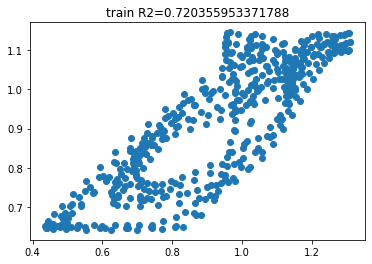

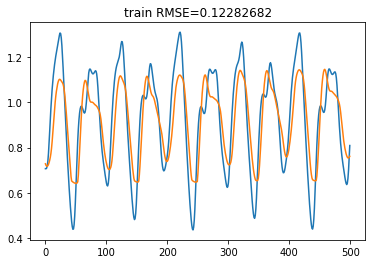

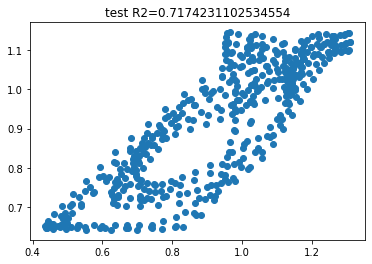

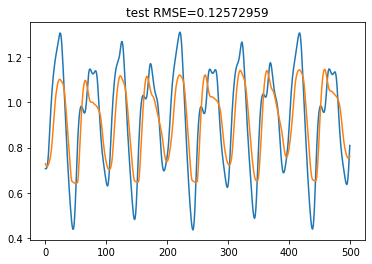

In [47]:
import matplotlib.pyplot as plot

plot1 = plot.figure(1)
plot.scatter(test_real_out,pred_test)
plot.title("train R2=%s"%r2.iloc[0,0])
plot1 = plot.figure(2)
plot.plot(test_real_out)
plot.plot(pred_test)
plot.title("train RMSE=%s"%rmse.iloc[0,0])
plot1 = plot.figure(3)
plot.scatter(test_real_out,pred_test)
plot.title("test R2=%s"%r2.iloc[0,1])
plot1 = plot.figure(4)
plot.plot(test_real_out)
plot.plot(pred_test)
plot.title("test RMSE=%s"%rmse.iloc[0,1])